<a href="https://colab.research.google.com/github/Sparten-Ashvinee/ERA/blob/main/S18/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/U-NET/

/content/drive/MyDrive/U-NET


In [13]:
!ls

 new_pet_data  'UNet from scratch.ipynb'


In [49]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [51]:
latent_dims = 2
autoencoder = VariationalAutoencoder(latent_dims).to(device) # GPU

data = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./mnist_data',
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=25,
        shuffle=True)

####Assigning random labels

In [52]:
dataset = iter(data)
for i in range(1):
  img, lab = next(dataset)
  idx = torch.randperm(lab.nelement())
  lab = lab.view(-1)[idx].view(lab.size())
  lab = torch.nn.functional.one_hot(lab, num_classes=10)

  dataset_new = torch.utils.data.TensorDataset(img, lab)
  data_loader_ = torch.utils.data.DataLoader(dataset_new, batch_size=25, shuffle=True)


In [53]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [54]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [55]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [56]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [57]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [75]:
def train(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum()
            #loss = torch.nn.KLDivLoss(size_average=False)(F.log_softmax(x, -1), x_hat)
            print('Training loss for epoch: ', epoch)
            print('Loss: ', loss)
            loss.backward()
            opt.step()
    return autoencoder

In [76]:
vae = VariationalAutoencoder(latent_dims).to(device) # GPU

In [77]:
autoencoder = train(vae, data_loader_, epochs=10)

Training loss for epoch:  0
Loss:  tensor(4632.6162, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  1
Loss:  tensor(4200.4160, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  2
Loss:  tensor(3806.1082, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  3
Loss:  tensor(3365.4248, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  4
Loss:  tensor(2887.4783, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  5
Loss:  tensor(2521.7866, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  6
Loss:  tensor(2098.1548, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  7
Loss:  tensor(1862.3074, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  8
Loss:  tensor(1724.5356, device='cuda:0', grad_fn=<SumBackward0>)
Training loss for epoch:  9
Loss:  tensor(1470.6832, device='cuda:0', grad_fn=<SumBackward0>)


In [80]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=5):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

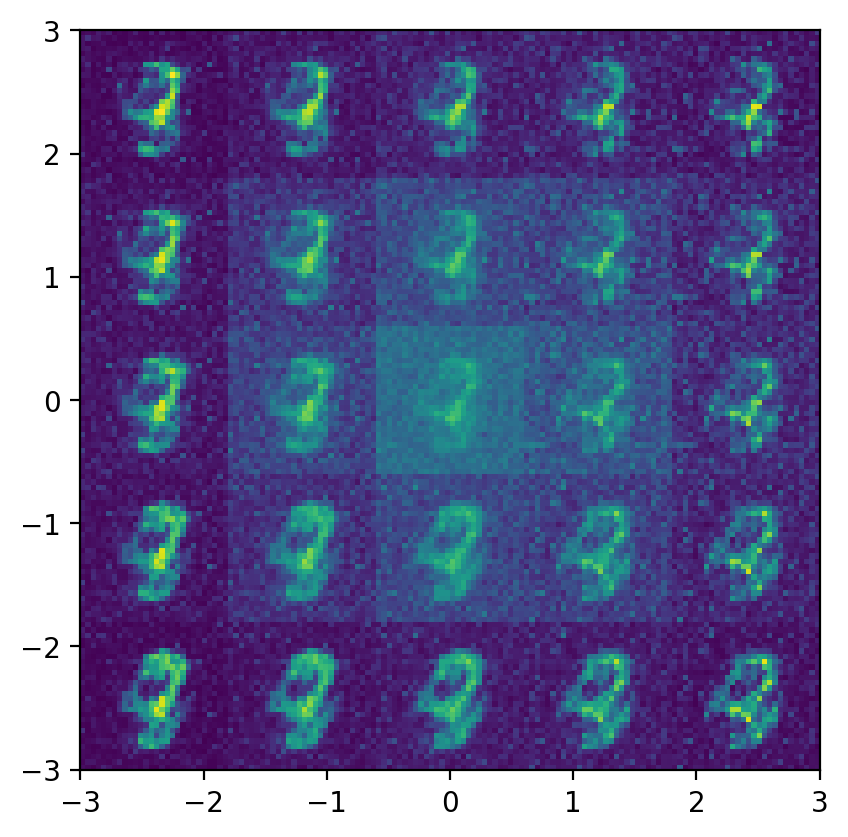

In [81]:
plot_reconstructed(vae, r0=(-3, 3), r1=(-3, 3))